# __Research Question:__

What set of criteria is most important to the sucess of a mutual fund? What about amongst ETFs? Which type of fund is more successful overall can can the success of a fund be accurately predicted based on these observed criteria?

### Importing:

In [57]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from   sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


import statsmodels.formula.api as smf
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

### Data overview:

The file contains 24,821 Mutual Funds and 1,680 ETFs with general aspects (as Total Net Assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as yeartodate, 2020-11) and financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, and beta). This data was scraped from Yahoo Finance by kaggle user Stefano Leone.

Link to dataset: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs


In [58]:

df_mf=pd.read_csv('Mutual Funds.csv')
df_etf=pd.read_csv('ETFs.csv')


C:\Users\camro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [59]:
print(df_mf.shape,'\n',df_mf.columns)

(24821, 173) 
 Index(['fund_symbol', 'fund_extended_name', 'fund_family', 'inception_date',
       'category', 'rating', 'return_rating', 'risk_rating',
       'investment_strategy', 'investment_type',
       ...
       'fund_sharpe_ratio_5years', 'category_sharpe_ratio_5years',
       'fund_sharpe_ratio_10years', 'category_sharpe_ratio_10years',
       'fund_treynor_ratio_3years', 'category_treynor_ratio_3years',
       'fund_treynor_ratio_5years', 'category_treynor_ratio_5years',
       'fund_treynor_ratio_10years', 'category_treynor_ratio_10years'],
      dtype='object', length=173)


# __DATA CLEANING APPENDIX__:


Throwing away  4 completely empty columns in df_etf - ['category_return_2019', 'category_return_2018', 'category_return_2017', 'category_return_2016']:

In [60]:
empty_cols2 = [col for col in df_etf.columns if df_etf[col].isnull().all()]
df_etf.drop(empty_cols2,
        axis=1,
        inplace=True)



Throwing away the unnecessary columns that don't contain information useful to our analysis in both df_mf and df_etf:

In [61]:
throwaway_cols=[
    'quarters_up',
    'quarters_down',
    'top10_holdings',
    'years_up',
    'years_down',
    'currency'
]
df_mf.drop(columns=throwaway_cols,axis=1,inplace=True)
df_etf.drop(columns=throwaway_cols[2:],axis=1,inplace=True)

df_etf.to_csv('NoEmptiesETFs.csv',index=False)
df_mf.to_csv('NoEmptiesMutual Funds.csv',index=False)


Creating a method that allows us to isolate sections of each data frame based on keywords in their column names:

In [62]:
### Creates and returns a subset of df_mf by keeping only the columns with 'keyword' in their column name. 
def cleanbykeyword(df,keyword):
    """
    Searches and creates a list of all of the column names in df that contain the keyword.
    Subsets the df according to this list, then creates a df_new dataframe with this 
    information and drops the corresponding columns from the original df.

    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
        
        
    Return: dataframe containing data matching keyword.
    """
    col_list=[ i for i in df.columns if (keyword in i)] 
    #print(col_list)
    df_new=df[col_list]
    df.drop(columns=col_list,axis=1,inplace=True) #removes duplicate data from df_mf masterframe
    df_new.insert(0,'fund_symbol',df.fund_symbol) #inserts the fund symbols as the 1st column of the new data set
    return (df_new)

Removing category data from the dataframe. Some of the category columns were not updated properly in the data set and therefore cannot be used in our analyses, we drop them to save space: 


In [63]:
df_mf_category_data=cleanbykeyword(df_mf,'category_')
df_etf_category_data=cleanbykeyword(df_etf,'category_')
df_mf_category_data.head(4)

,fund_symbol,category_net_annual_expense_ratio,category_return_ytd,category_return_1month,category_return_3months,category_return_1year,category_return_3years,category_return_5years,category_return_10years,category_return_2019,...,category_r_squared_10years,category_standard_deviation_3years,category_standard_deviation_5years,category_standard_deviation_10years,category_sharpe_ratio_3years,category_sharpe_ratio_5years,category_sharpe_ratio_10years,category_treynor_ratio_3years,category_treynor_ratio_5years,category_treynor_ratio_10years
0,AAAAX,1.01,-5.47,-1.49,-1.00,-2.08,1.10,3.97,4.61,16.10,...,0.89,0.12,0.10,0.10,0.00,0.00,0.00,-0.00,0.03,0.04
1,AAADX,0.82,0.07,-1.33,-0.15,3.88,4.90,6.23,7.13,19.23,...,0.92,0.12,0.10,0.09,0.00,0.01,0.01,0.03,0.05,0.06
2,AAAGX,1.04,17.54,-2.64,1.64,25.92,15.98,14.64,14.19,31.90,...,0.88,0.19,0.16,0.15,0.01,0.01,0.01,0.14,0.13,0.13
3,AAAIX,0.73,-2.67,-1.46,0.19,1.83,3.98,6.21,7.46,21.35,...,0.93,0.15,0.12,0.11,0.00,0.00,0.01,0.02,0.04,0.05


Cleaning by fund return:


In [64]:
df_mf_return_history=cleanbykeyword(df_mf,'_return_')
df_etf_return_history=cleanbykeyword(df_etf,'_return_').dropna()

df_etf_return_history.to_csv('returnsETFs.csv',index=False)
df_mf_return_history.to_csv('returnsMutual Funds.csv',index=False)

#Adds fund_return_ytd column to main datafrme and removes from return history subframe
df_mf['fund_return_ytd']=df_mf_return_history['fund_return_ytd']
df_etf['fund_return_ytd']=df_etf_return_history['fund_return_ytd']
df_mf_return_history=df_mf_return_history.drop(columns=['fund_return_ytd'])
df_etf_return_history=df_etf_return_history.drop(columns=['fund_return_ytd'])

df_etf_return_history.head(2)

,fund_symbol,fund_return_1month,fund_return_3months,fund_return_1year,fund_return_3years,fund_return_5years,fund_return_10years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2014,fund_return_2013,fund_return_2012,fund_return_2011,fund_return_2010,fund_mean_annual_return_3years,fund_mean_annual_return_5years,fund_mean_annual_return_10years
54,1557,4.76,3.35,12.84,10.15,9.77,13.04,31.29,-4.45,21.69,11.80,1.34,13.53,32.21,15.84,2.06,14.93,0.93,0.87,1.10
117,AAXJ,1.85,5.02,15.34,3.46,8.94,4.30,17.40,-14.81,40.52,4.83,-9.85,3.93,2.48,21.39,-20.01,15.53,0.43,0.81,0.47


Cleaning by standard deviation:


In [65]:
df_mf_standard_deviations= cleanbykeyword(df_mf,'standard_deviation')
df_etf_standard_deviations=cleanbykeyword(df_etf,'standard_deviation').dropna()
df_etf_standard_deviations.to_csv('stdsETFs.csv',index=False)
df_mf_standard_deviations.to_csv('stdsMutual Funds.csv',index=False)

df_mf_standard_deviations.head(4)
df_etf_standard_deviations.head(4)

,fund_symbol,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years
0,1305,14.38,14.75,16.89
1,1306,14.38,14.75,16.83
2,1308,14.38,14.75,16.90
3,1310,15.16,16.21,18.39


Cleaning by net annual expense, Sharpe and Treynor Ratios:


In [66]:
df_mf_ratios=cleanbykeyword(df_mf,'_ratio')
df_etf_ratios=cleanbykeyword(df_etf,'_ratio').dropna()

df_etf_ratios.to_csv('ratiosETFs.csv',index=False)
df_mf_ratios.to_csv('ratiosMutual Funds.csv',index=False)
df_mf_ratios.head(4)
df_etf_ratios.head(4)



,fund_symbol,fund_net_annual_expense_ratio,price_earnings_ratio,price_book_ratio,price_sales_ratio,price_cashflow_ratio,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years,fund_treynor_ratio_3years,fund_treynor_ratio_5years,fund_treynor_ratio_10years
0,1305,0.00,12.92,1.18,0.81,5.41,0.34,0.59,0.60,3.92,8.01,9.29
1,1306,0.05,12.92,1.18,0.81,5.41,0.34,0.59,0.61,3.94,8.03,9.33
2,1308,0.00,12.92,1.18,0.81,5.44,0.34,0.59,0.60,3.93,8.03,9.31
3,1310,0.00,11.34,1.12,1.07,4.06,0.14,0.34,0.44,1.00,4.08,6.18


Cleaning by Alpha value:


In [67]:
df_mf_alpha=cleanbykeyword(df_mf,'alpha')
df_mf_alpha.head(4)
df_etf_alpha=cleanbykeyword(df_etf,'alpha')
df_etf_alpha.head(4)



,fund_symbol,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years
0,1305,0.29,0.39,0.35
1,1306,0.31,0.40,0.38
2,1308,0.30,0.41,0.36
3,1310,-2.58,-3.41,-2.56


Cleaning by Beta value:


In [68]:
df_mf_beta=cleanbykeyword(df_mf,'beta')
df_mf_beta.head(4)
df_etf_beta=cleanbykeyword(df_etf,'beta')
df_etf_beta.head(4)



,fund_symbol,fund_beta_3years,fund_beta_5years,fund_beta_10years
0,1305,1.00,0.98,0.99
1,1306,1.00,0.98,0.98
2,1308,1.00,0.98,0.99
3,1310,1.04,1.06,1.06



Cleaning by Sector:


In [69]:
df_mf_sector=cleanbykeyword(df_mf,'sector')
df_etf_sector=cleanbykeyword(df_etf,'sector')

df_etf_sector.to_csv('sectorsETFs.csv',index=False)
df_mf_sector.to_csv('sectorsMutual Funds.csv',index=False)
df_etf_sector.head(4)

,fund_symbol,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology
0,1305,7.81,17.26,11.73,3.19,9.44,7.05,1.96,4.95,1.7,20.29,14.61
1,1306,7.81,17.26,11.73,3.19,9.43,7.06,1.96,4.95,1.7,20.29,14.62
2,1308,7.74,17.33,11.57,3.22,9.53,7.07,1.99,4.98,1.7,20.23,14.62
3,1310,2.41,14.25,16.26,1.74,7.93,4.55,0.00,15.52,2.0,16.26,19.06


Cleaning by Credit:


In [70]:
df_mf_credit=cleanbykeyword(df_mf,'credit').dropna()
df_etf_credit=cleanbykeyword(df_etf,'credit').dropna()
df_mf_credit.to_csv('creditsMutual Funds.csv',index=False)
df_mf_credit.head(4)


,fund_symbol,credit_us_government,credit_aaa,credit_aa,credit_a,credit_bbb,credit_bb,credit_b,credit_below_b,credit_other_ratings
3,AAAIX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70
7,AAARX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70
9,AAATX,0.0,66.37,4.40,8.79,9.01,5.64,3.23,1.09,1.47
10,AAAUX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70


Cleaning by r squared coefficient:


In [71]:
df_mf_rsquare=cleanbykeyword(df_mf,'squared')
df_mf_rsquare.head(4)
df_etf_rsquare=cleanbykeyword(df_etf,'squared')
df_etf_rsquare.head(4)



,fund_symbol,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years
0,1305,99.72,99.70,99.68
1,1306,99.72,99.69,99.68
2,1308,99.72,99.69,99.68
3,1310,96.51,97.19,96.63


Cleaning by asset:


In [72]:
df_mf_asset=cleanbykeyword(df_mf,'asset')
df_etf_asset=cleanbykeyword(df_etf,'asset')

df_etf_asset.to_csv('assetsETFs.csv',index=False)
df_mf_asset.to_csv('assetsMutual Funds.csv',index=False)
df_mf_asset.head(4)


,fund_symbol,asset_cash,asset_stocks,asset_bonds,asset_others,asset_preferred,asset_convertable,net_asset_value
0,AAAAX,1.88,63.87,15.31,18.95,0.00,0.00,6.979100e+08
1,AAADX,3.49,48.14,48.37,0.00,0.00,0.00,8.938000e+07
2,AAAGX,1.54,98.46,0.00,0.00,0.00,0.00,1.490000e+09
3,AAAIX,2.75,78.52,18.48,0.01,0.07,0.14,7.072500e+08


Merges datasets containing R-Squares, Alpha, and Beta values into a single data set:


In [73]:
df_mf_stats=df_mf_rsquare.merge(df_mf_alpha,how='left')
df_mf_stats=df_mf_stats.merge(df_mf_beta,how='left')
df_mf_stats.to_csv('statsMutual Funds.csv',index=False)
df_mf_stats.head()

df_etf_stats=df_etf_rsquare.merge(df_etf_alpha,how='left')
df_etf_stats=df_etf_stats.merge(df_etf_beta,how='left')
df_etf_stats.to_csv('statsETFs.csv',index=False)
df_etf_stats.head()




,fund_symbol,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years,fund_beta_3years,fund_beta_5years,fund_beta_10years
0,1305,99.72,99.70,99.68,0.29,0.39,0.35,1.00,0.98,0.99
1,1306,99.72,99.69,99.68,0.31,0.40,0.38,1.00,0.98,0.98
2,1308,99.72,99.69,99.68,0.30,0.41,0.36,1.00,0.98,0.99
3,1310,96.51,97.19,96.63,-2.58,-3.41,-2.56,1.04,1.06,1.06
4,1311,96.52,97.20,96.64,-2.56,-3.39,-2.50,1.04,1.06,1.06


String to Float function

In [ ]:
def str_to_float(dataFrame,colName):
    '''
    This method converts the values of a specific column in a given dataframe from strings to floats
    '''
    for x in dataFrame['colName']:
        if type(x) == str:
            if ',' in x:
                x = x.replace(',', '')
            f = float(x)
            x = f
        if type(x) != float:
             print("wrong")

# __EXPLORATORY ANALYSIS__

In [74]:
#creates a pie chart representing the relative distribution of funds in a certain category 
def pie_chart(df,column):
    '''
    Param df: Pandas dataframe
    Param column: column in df that is to be analyzed.
    '''
    grouped=df.groupby(column).fund_symbol.count().to_frame()
    plt.pie(grouped.fund_symbol,labels=grouped.index,autopct='%.2f%%')
    plt.show()

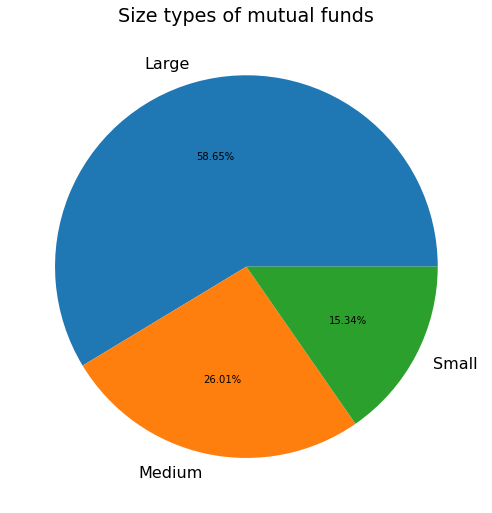

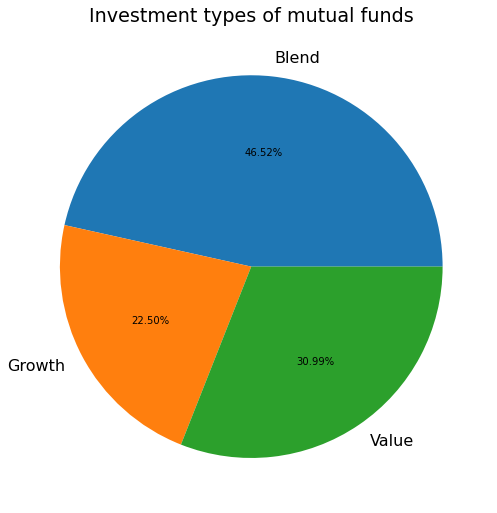

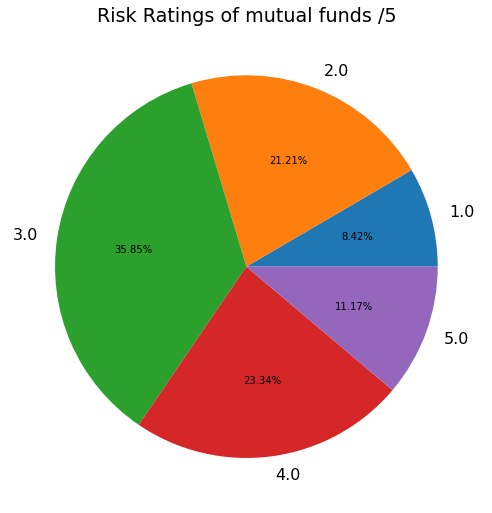

In [75]:
#Basic analysis of mutual fund distributions
plt.title('Size types of mutual funds')
pie_chart(df_mf,'size_type')
plt.title('Investment types of mutual funds')
pie_chart(df_mf,'investment_type')
plt.title('Risk Ratings of mutual funds /5')
pie_chart(df_mf,'risk_rating')


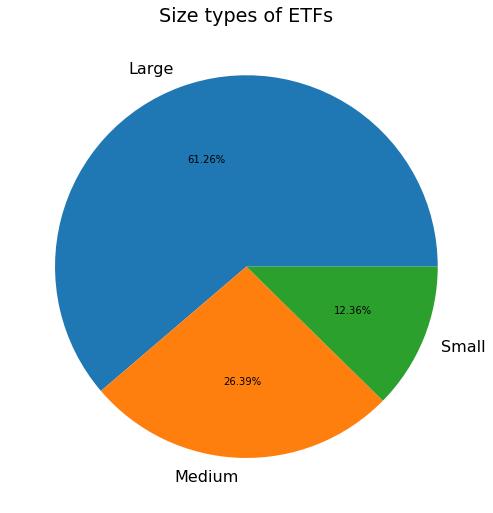

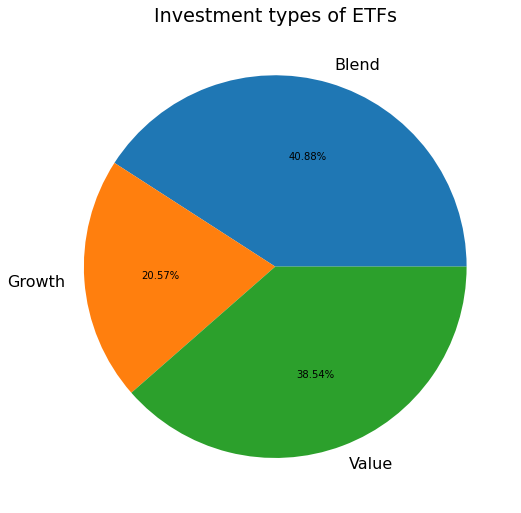

In [76]:
#Basic analysis of ETF distributions
plt.title('Size types of ETFs')
pie_chart(df_etf,'size_type')
plt.title('Investment types of ETFs')
pie_chart(df_etf,'investment_type')



In [77]:
#creats a pie chart representing the % composition of a certain range of values in a dataset.
def percent_comp_bar(df,cols,keyword):
    """
    Creates a pie chart for a given DataFrame subset. Each section in the pie chart
    represents a column mean within the dataframe, which corresponds to a % invested
    in a given category (sector/asset)
    
    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
    """
    col_names=[]
    other=0
    col_sums=[]
    for column in cols:
        col_sum=df[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names.append(column.replace(keyword,''))
            col_sums.append(df[column].mean())
    if(other>0.1):
        col_names.append('other')
        col_sums.append(other)
    plt.pie(col_sums,labels=col_names,autopct='%.2f%%') 
    plt.show()


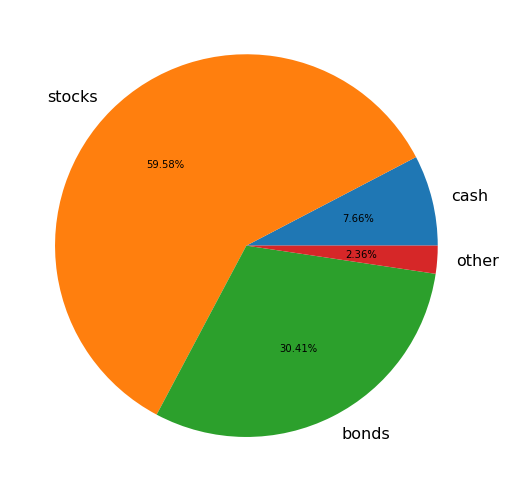

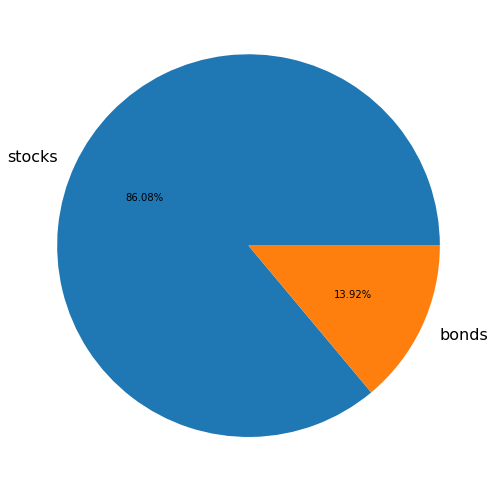

In [78]:
cols=[i for i in df_mf_asset.columns[1:7]]
percent_comp_bar(df_mf_asset,cols,'asset_')
cols=[i for i in df_etf_asset.columns[1:3]]
percent_comp_bar(df_etf_asset,cols,'asset_')

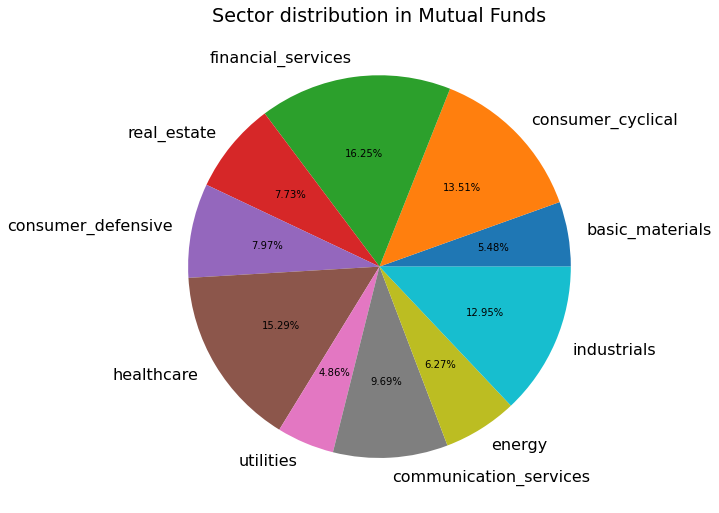

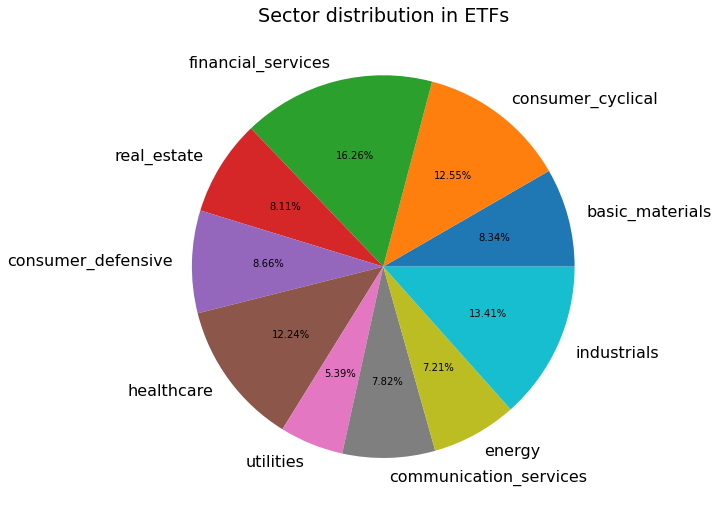

In [79]:
# Percentage invested in each sector
cols=[i for i in df_mf_sector.columns[1:11]]
plt.title('Sector distribution in Mutual Funds')
percent_comp_bar(df_mf_sector,cols,'sector_')
print('\n')
plt.title('Sector distribution in ETFs')
percent_comp_bar(df_etf_sector,cols,'sector_')


In [80]:
#Creates a bar plot of the 20 most common values in the given column
def distribution_by_category(df):
    '''
    Param df: dataframe of funds containing category type.
    
    '''
    cat_count=df['category'].value_counts()[:20]
    sns.barplot(x=cat_count.values,y=cat_count.index)
    plt.title('Distribution by Category')
    plt.tight_layout
    plt.show()

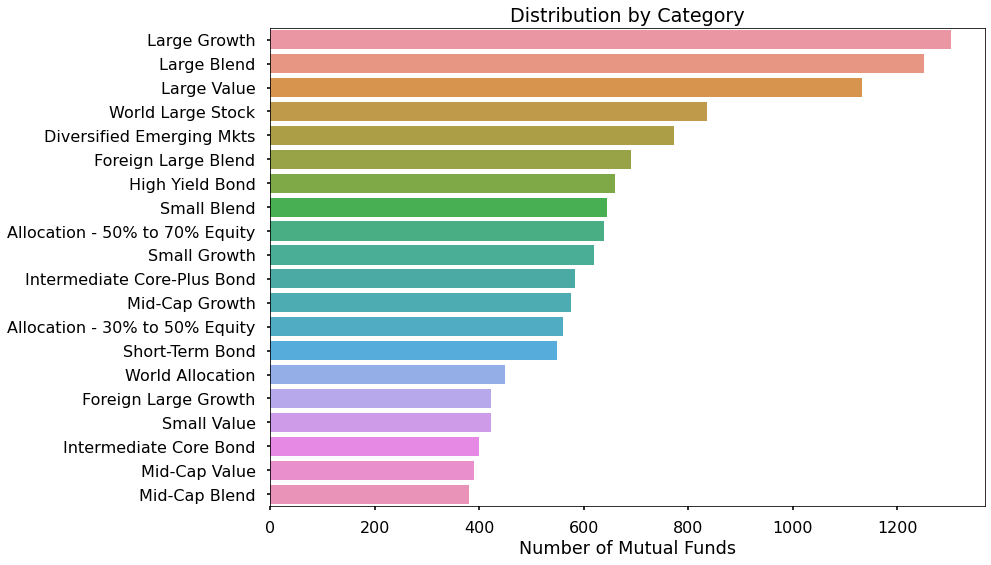

In [81]:
plt.xlabel('Number of Mutual Funds')
distribution_by_category(df_mf)

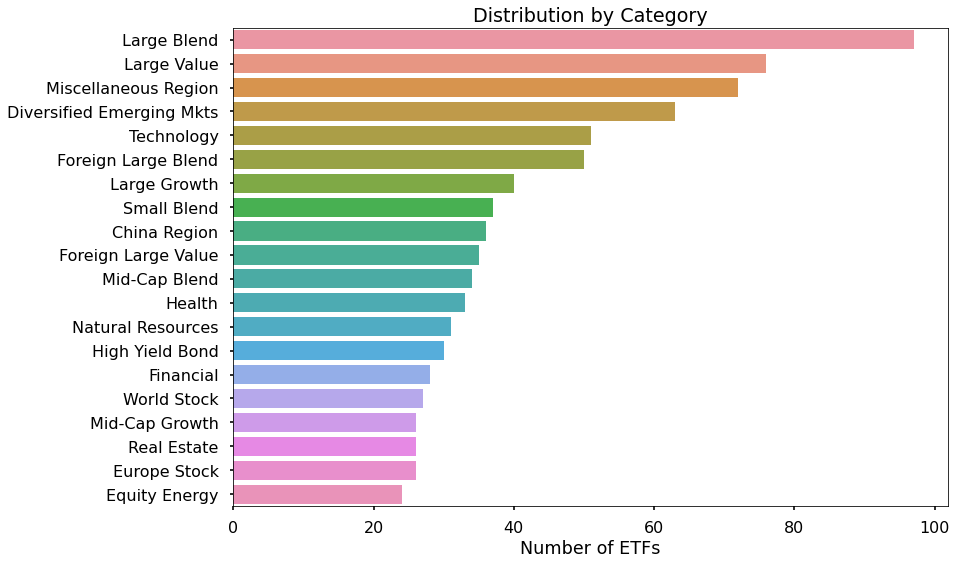

In [82]:
plt.xlabel('Number of ETFs')
distribution_by_category(df_etf)

In [83]:
#Draws a boxplot representing the dependent column as a function of the independent column
def dep_by_indep_boxplot(df_joined,independent,dependent,fundtype):
    '''
    Param df_joined: dataframe containing both the independent and dependent columns
    Param independent: column which serves as the independent variable
    Param dependent: column which serves as the dependent variable which is analyzed and plotted according to the dependent column.
    Param fundtype: Name of fund that is printed at the start of execution.
    '''
    
    print('\n Distribution of {} according to {} in {}'.format(dependent,independent,fundtype)+':\n')

    colors=['blue','grey','magenta','yellow','cyan','orange']    
    criteria=[i for i in df_joined[independent].sort_values(ascending=True).dropna().unique()]
    col_count=len(criteria)
    table=df_joined.melt(id_vars=[independent],value_vars=[dependent]).dropna()
    
    fig,ax=plt.subplots(nrows=1,ncols=col_count,figsize=(15,9))
    for i in range(0,col_count):
        sns.boxplot(data=table.where(table[independent]==criteria[i]).value,ax=ax[i],color=colors[i])
        ax[i].set_title(independent + ' = ' + str(criteria[i]))
        plt.tight_layout()
    plt.show()
    



 Distribution of price_earnings_ratio according to risk_rating in Mutual Funds:



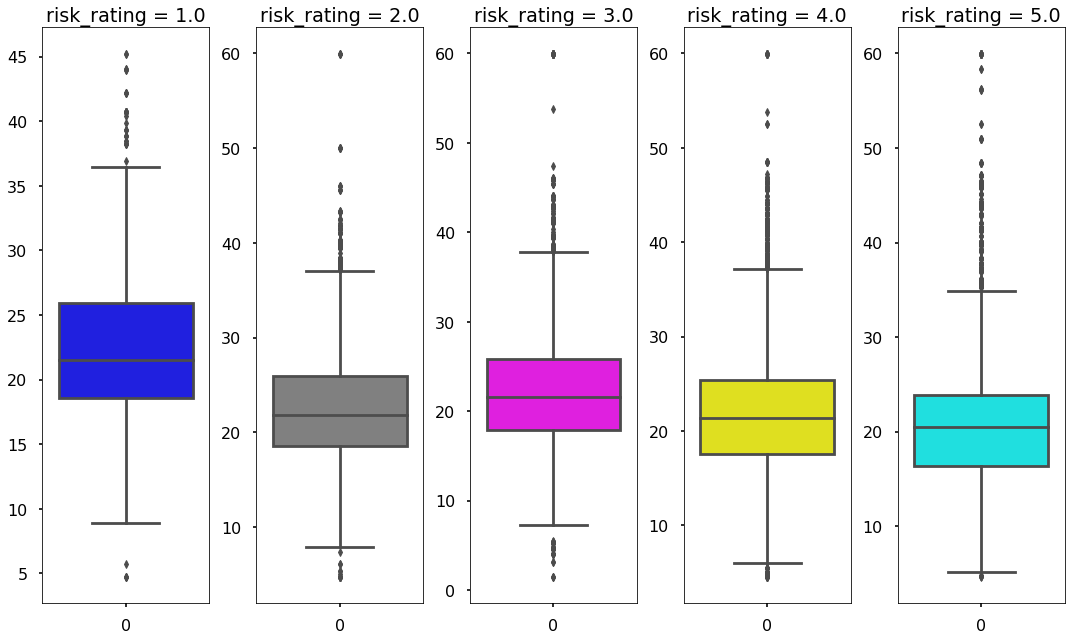

In [84]:
#Price earnings ratio vs. risk rating for Mutual Funds
joined=pd.merge(df_mf,df_mf_ratios)
dep_by_indep_boxplot(joined,'risk_rating','price_earnings_ratio','Mutual Funds')


 Distribution of fund_alpha_3years according to size_type in Mutual Fund:



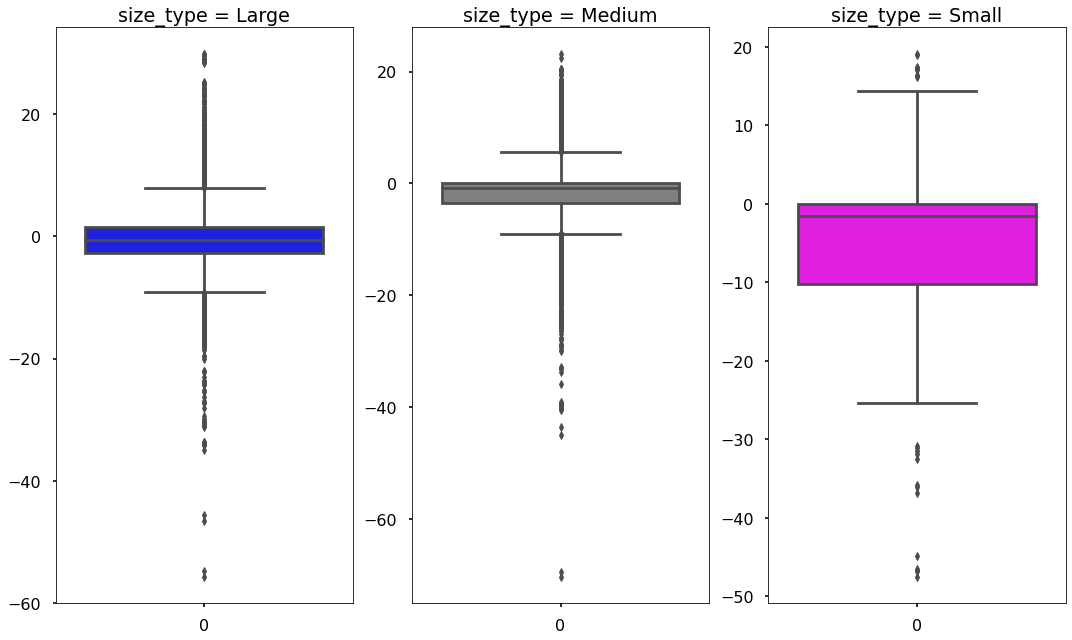

In [85]:
#Mutual Fund size vs. alpha 3 years value
joined=pd.merge(df_mf,df_mf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years','Mutual Fund')



 Distribution of fund_alpha_3years according to size_type in ETFs:



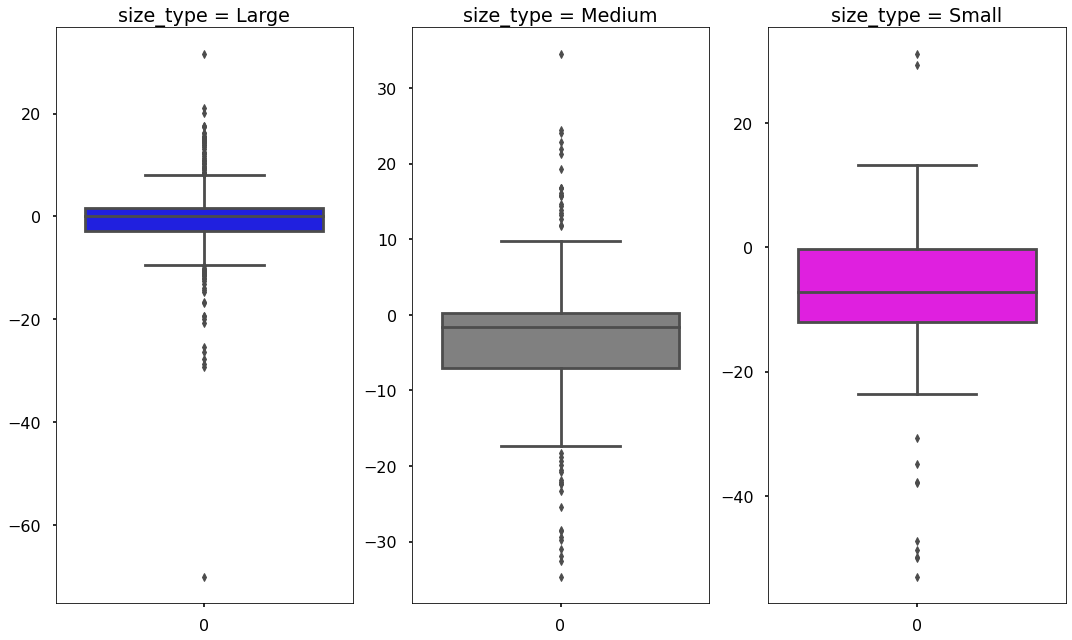

In [86]:
#ETF Fund size vs. alpha 3 years score
joined=pd.merge(df_etf,df_etf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years','ETFs')


 Distribution of fund_return_ytd according to investment_type in Mutual Fund:



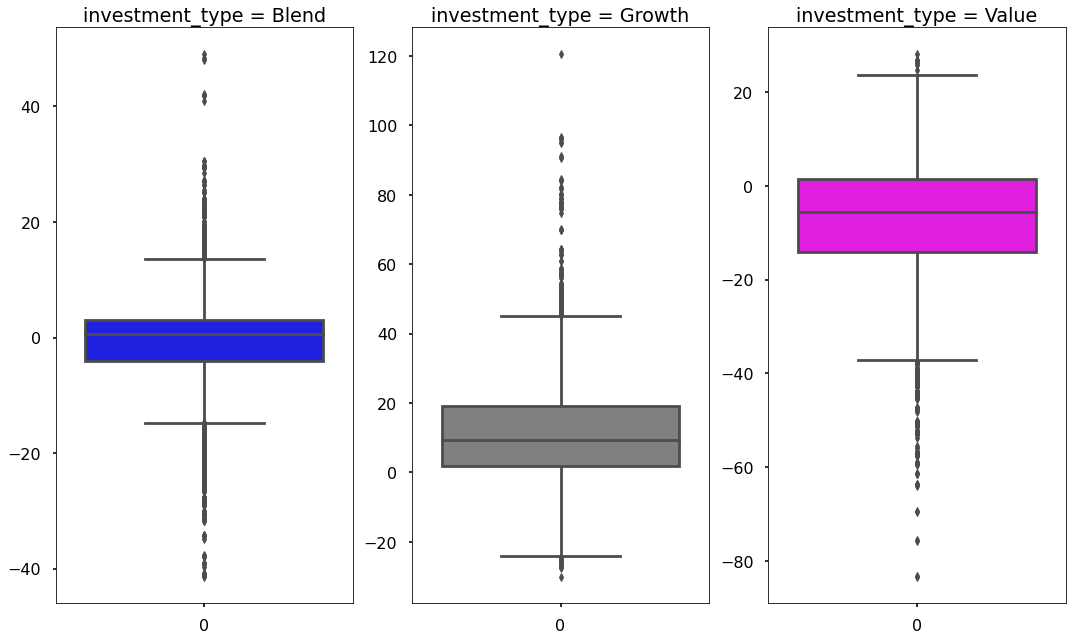

In [87]:
#Investment type vs. mutual fund YTD return
joined=pd.merge(df_mf,df_mf_return_history)
dep_by_indep_boxplot(joined,'investment_type','fund_return_ytd','Mutual Fund')


 Distribution of fund_return_ytd according to investment_type in ETFs:



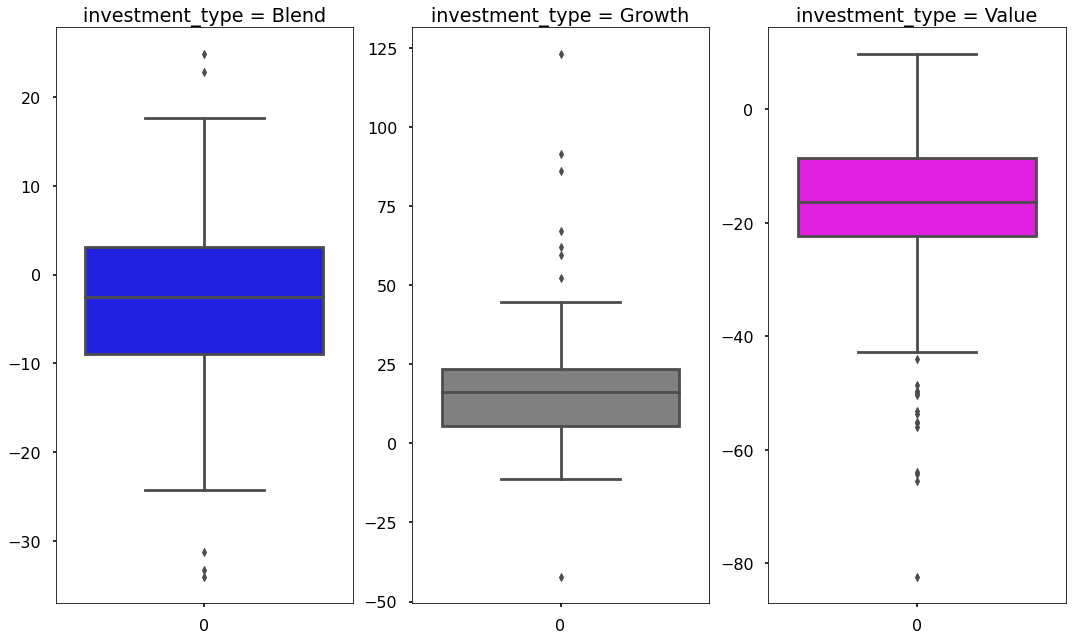

In [88]:
#Investment type vs. mutual fund YTD return
joined=pd.merge(df_etf,df_etf_return_history)
dep_by_indep_boxplot(joined,'investment_type','fund_return_ytd','ETFs')

# __DATA LIMITATIONS__:

The two main limitations of our data set that have been noticed are: 

1. Missing information within specific columns of the dataset. For example the column 'median_market_cap' in the ETF dataframe contains lots of values of 0.0 .This makes analysis of median market cap more difficult - how do we deal with these zero values? Excluding these values of 0.0 might introduce bias into our analysis. The ETFs that have median market caps of 0.0 might share a common trait that is no longer being factored into the analysis if we were to remove all these ETfs. Moreover, many of the entries in columns containing category data are either missing or not helpful.

        --> We think that the cause for this is that not all funds have the same inception date. For instance, a fund that started in 2017 years ago will be   missing data in any column corresponding to 2016 or before. This creates problems when trying to analyze general trends over time as data may be unevenly distributed.
        
        
2. The data of ETfs and Mfs are contained in separate CSV files. There is no obvious way for us to merge this data into a single CSV file. If we were to merge these CSV files the resulting CSV file would not be very readable. 

# __QUESTIONS FOR REVIEWRS__:

Should we include our the results of our analysis in our .ipynb file or let readers draw their own conclusions?

Do you find it more intresting to compare mutual funds against ETFs or to compare/analyze different funds within the same category?

Suppose you had another dataset of mutual funds/ETFS for Europe rather than the US. What are some interesting analysis that can be performed?

# __Analysis for phase 4__:


__TO DO__:  find out where to put this section 'analysis for phase 4'

__Start of section:__

In [89]:
#Creates two new dataframes where only the highest correlated variables are stored
df_mf_highest_corrs=pd.DataFrame(index=['Correlation'])
df_etf_highest_corrs=pd.DataFrame(index=['Correlation'])

#Removes NaNs from fund return column
df_mf.dropna(subset=['fund_return_ytd'],inplace=True)
df_etf.dropna(subset=['fund_return_ytd'],inplace=True)



__Methods used in correlations:__

In [90]:
## returns a data frame of the correlations of the variables in the 'predictors' array with the 'independentVariable' in the data frame 'df'
def get_correlations(df,predictors,independentVariable):
    
    #Scaling columns with discrete variables
    scaled = StandardScaler().fit_transform(df[predictors])
    df[predictors]=scaled
    
    df_corr=pd.DataFrame(index=['correlation'],columns=predictors)
    for predictor in predictors:
        model=LinearRegression().fit(df[[predictor]],df[independentVariable])
        correlation=model.score(df[[predictor]],df[independentVariable])
        df_corr[predictor]=round(correlation,4)
        
    return df_corr.T

In [91]:
## filters the correlations in the data frame 'df_corrs' and adds the correlations greater than .10
## pass in 'df_mf_highest_corrs' or 'df_etf_highest_corrs' in the variable 'df_high_corrs' for respective fund types
def filter_correlations(df_corrs,df_high_corrs):
    for i in df_corrs.index:
        corr=df_corrs.loc[i,'correlation']
        if (corr>.10 or corr <-.10):
                df_high_corrs[i]=corr

In [92]:
## Generates a bar plot of the correlations in the data frame 'df_corr' that have correlations greater than the value 'cutoff' 
## the plot is titled 'title' and has index labels of font size 'labelsize'
def corr_visualize(df_corr,independentVariable,cutoff,title,labelsize):
    df_cutoffs=df_corr[df_corr['correlation']>cutoff]
    sns.barplot(x=df_cutoffs.index,y=df_cutoffs['correlation'],palette='rocket')
    plt.title(title)
    plt.tick_params(labelsize=labelsize)
    plt.tight_layout()


__Putting it all together: Using get_correlations, filter_correlations, and corr_visualize to determine which ratios are most correlated with fund_return_ytd for each type of fund__

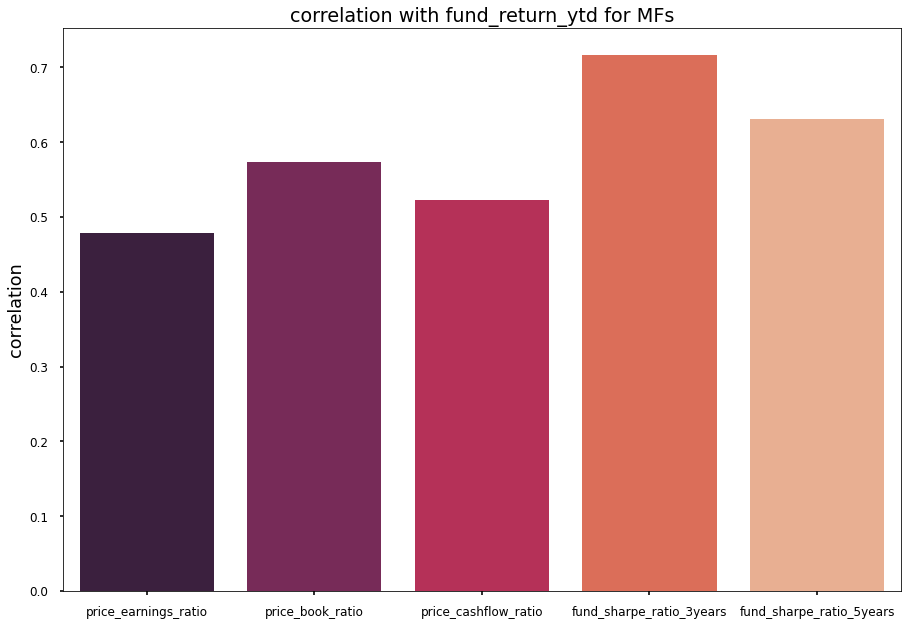

In [93]:
joined=pd.merge(df_mf,df_mf_ratios).dropna()

predictors=['median_market_cap', 'bond_maturity', 'bond_duration', 'fund_yield',
        'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio',
       'fund_sharpe_ratio_3years', 'fund_sharpe_ratio_5years',
       'fund_sharpe_ratio_10years']


df_corrs=get_correlations(joined,predictors,'fund_return_ytd')
filter_correlations(df_corrs,df_mf_highest_corrs)
corr_visualize(df_corrs,'fund_return_ytd',.35,'correlation with fund_return_ytd for MFs',12)


__removes quarterly data__:

In [94]:
cleanbykeyword(df_mf_return_history,'_q')
df_mf_return_history.columns

Index(['fund_symbol', 'fund_return_1month', 'fund_return_3months',
       'fund_return_1year', 'fund_return_3years', 'fund_return_5years',
       'fund_return_10years', 'fund_return_2019', 'fund_return_2018',
       'fund_return_2017', 'fund_return_2016', 'fund_return_2015',
       'fund_return_2014', 'fund_return_2013', 'fund_return_2012',
       'fund_return_2011', 'fund_return_2010',
       'fund_mean_annual_return_3years', 'fund_mean_annual_return_5years',
       'fund_mean_annual_return_10years'],
      dtype='object')

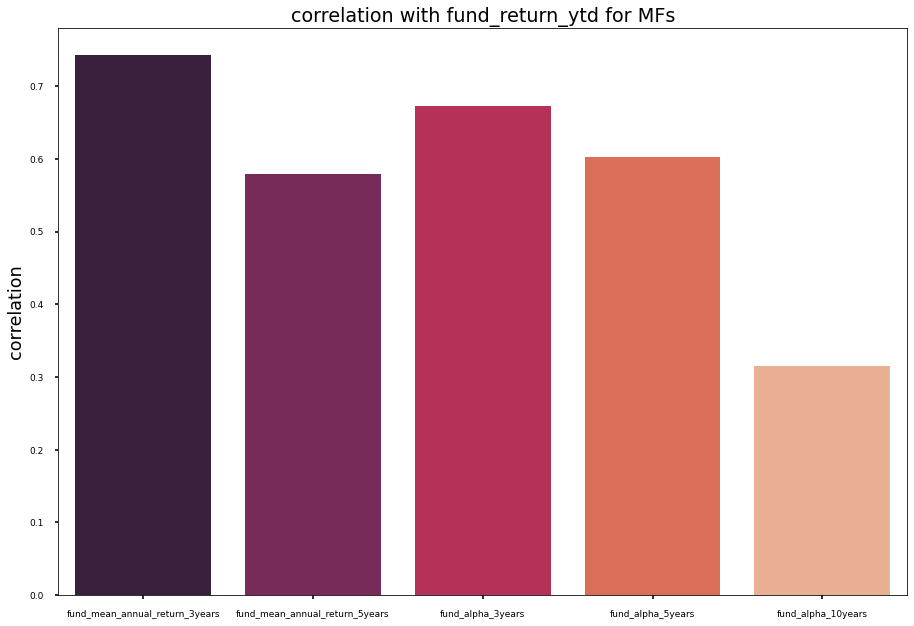

In [95]:
joined=pd.merge(df_mf,df_mf_return_history,on=['fund_symbol']).dropna()
joined=joined.merge(df_mf_stats).dropna(how='all')

predictors=['fund_mean_annual_return_3years', 'fund_mean_annual_return_5years',
       'fund_mean_annual_return_10years','fund_r_squared_3years',
       'fund_r_squared_5years', 'fund_r_squared_10years', 'fund_alpha_3years',
       'fund_alpha_5years', 'fund_alpha_10years', 'fund_beta_3years',
       'fund_beta_5years', 'fund_beta_10years']

scaled = StandardScaler().fit_transform(joined[predictors])
joined[predictors]=scaled

df_corrs=get_correlations(joined,predictors,'fund_return_ytd')
filter_correlations(df_corrs,df_mf_highest_corrs)
corr_visualize(df_corrs,'fund_return_ytd',.25,'correlation with fund_return_ytd for MFs',9)

**Now, we move on to improving the accuracy of our results by implementing bootstrap sampling and including categorical variables such as size type.**

In [96]:
#To reduce influence of outliers, we implement bootstrap sampling and calculate the average correlation of multiple, normalized samples instead:
def bootstrap_correlations(df,predictors,index,num_trials,sample_size):
    df.dropna(subset=predictors,inplace=True)
    #creates new dataframe to store correlation data for each trial
    df_corr_trials=pd.DataFrame(index=np.arange(num_trials),columns=predictors)
    
    for i in range(num_trials):
        sample=df.sample(n=sample_size, replace=True)
        df_corr=get_correlations(sample,predictors,'fund_return_ytd')
        corr_col=df_corr.correlation
        for w in range(len(corr_col)):
            df_corr_trials.iloc[i,w]=corr_col[w]
    
    df_average_corrs=pd.DataFrame(index=['correlation'],columns=predictors)
    for col in df_corr_trials.columns:
        mean=df_corr_trials[col].mean()
        df_average_corrs.loc['correlation',col]=mean
    return df_average_corrs.T



In [97]:
joined=pd.merge(df_mf,df_mf_return_history,on=['fund_symbol'])
joined=joined.merge(df_mf_stats)
#joined.dropna(inplace=True)

inputs=['fund_alpha_3years',
       'fund_alpha_5years', 'fund_alpha_10years', 'fund_beta_3years',
       'fund_beta_5years', 'fund_beta_10years']
joined.columns
corrs=bootstrap_correlations(joined,inputs,'fund_return_ytd',50,30)
filter_correlations(corrs,df_mf_highest_corrs)
corrs.head()

,correlation
fund_alpha_3years,0.647138
fund_alpha_5years,0.574494
fund_alpha_10years,0.325712
fund_beta_3years,0.04823
fund_beta_5years,0.048314


**We observe that compared to classic lin reg, the bootstrap correlations tend to have slightly different correlations. In particular, highly correlated variables have their influence reduced and mid/low correlated variables have the correlations slightly exaggerated.**

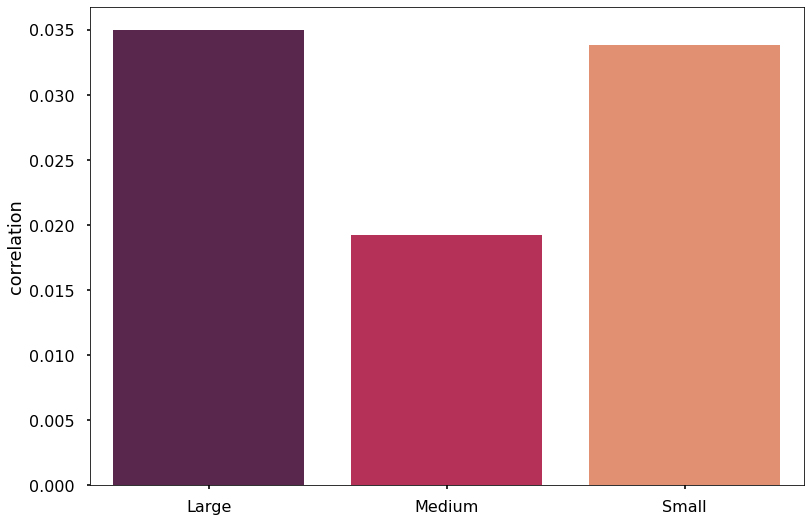

In [98]:
#Start of Binary Variable Analysis
from sklearn.preprocessing import StandardScaler
df_sizes=df_mf.join(pd.get_dummies(df_mf['size_type']))
df_sizes.head()
df_sizes.dropna(subset=['size_type','fund_return_ytd'],inplace=True)

# scale our data
cols=['median_market_cap', 'bond_maturity', 'bond_duration', 'fund_yield','fund_return_ytd']
scaled = StandardScaler().fit_transform(df_sizes[cols])
df_sizes[cols]=scaled

corrs=bootstrap_correlations(df_sizes,['Large','Medium','Small'],'fund_return_ytd',100,50)
sns.barplot(x=corrs.index,y=corrs.correlation,palette='rocket')

In [99]:
#Function that uses get_dummies to calculate the correlations of categorical columns such as size_type 
def categorical_corrs(df,dummycols,index):
    df.dropna(subset=dummycols,inplace=True)
    df_dummies=df
    dummy_list=[]
    for dummycol in dummycols:
        dummy_list.extend(df[dummycol].unique())
        dummy_df=pd.get_dummies(df[dummycol])
        df_dummies=df_dummies.join(dummy_df)
    df_cat_corrs=bootstrap_correlations(df_dummies,dummy_list,'fund_return_ytd',100,60)
    return df_cat_corrs

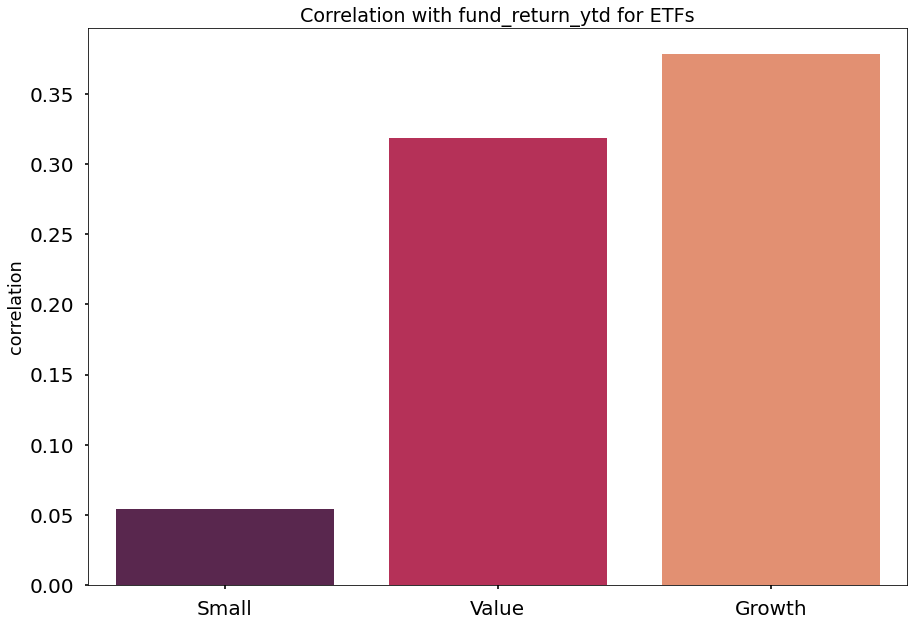

In [100]:
#Example of using categorical_corrs function to see which size/investment types are most correlated with fund return
etf_corrs=categorical_corrs(df_etf,['size_type','investment_type'],'fund_return_ytd')
corr_visualize(etf_corrs,'fund_return_ytd',.05,'Correlation with fund_return_ytd for ETFs',20)

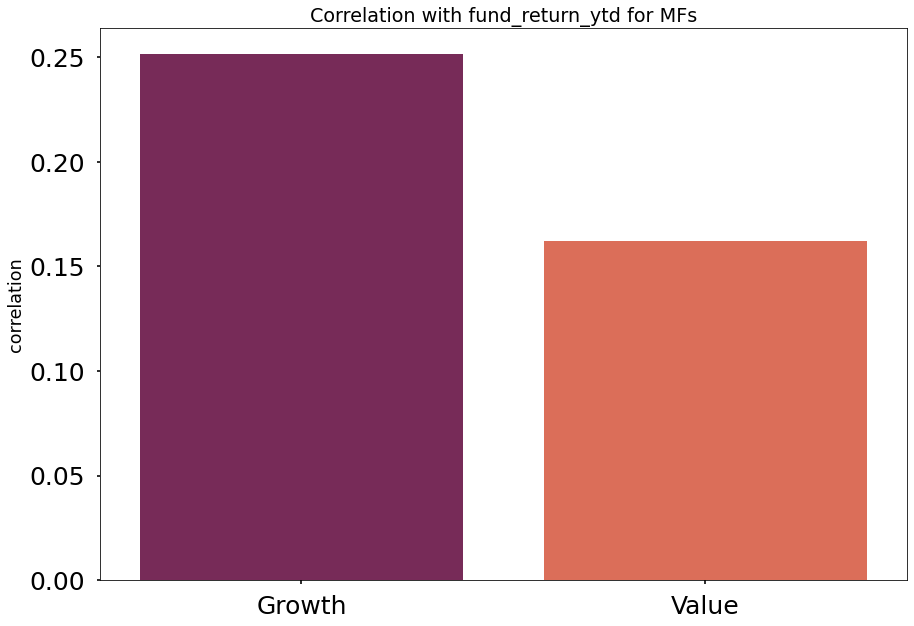

In [101]:
#Same as previous cell except for MFs
mf_corrs=categorical_corrs(df_mf,['size_type','investment_type'],'fund_return_ytd')
corr_visualize(mf_corrs,'fund_return_ytd',.05,'Correlation with fund_return_ytd for MFs',25)

**As we can see from the above code cell, for both MFs and ETFs, an investment type of growth or value is shown to significantly improve fund return when compared to an investment type of blend. Furthermore, we see that fund size has little influence of fund performance.**

# Cameron: analysis of correlation with fund return
__Finding the different variables that most correlate with short term medium term and long term returns__

### SHORT TERM

__mutual funds__

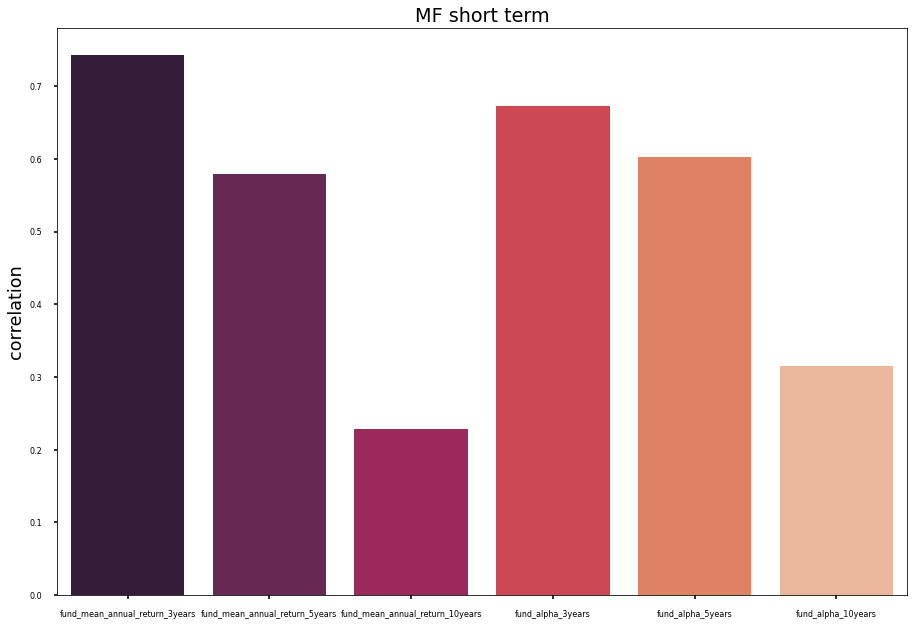

In [102]:
joined=pd.merge(df_mf,df_mf_ratios).dropna()
joined=joined.merge(df_mf_return_history).dropna()

predictors=['median_market_cap', 'bond_maturity', 'bond_duration', 'fund_yield',
        'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio']

mf_short=get_correlations(joined,predictors,'fund_return_1year')
filter_correlations(mf_corrs,df_mf_highest_corrs)
corr_visualize(df_corrs,'fund_return_1year',.20,'MF short term',8)



### ETFS

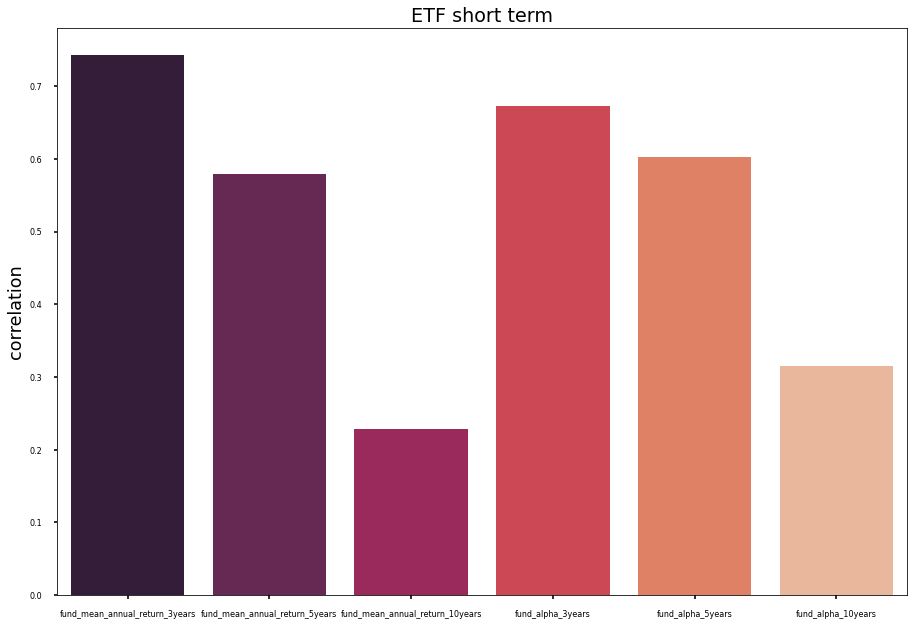

In [103]:
joined=pd.merge(df_etf,df_etf_ratios).dropna()
joined=joined.merge(df_etf_return_history).dropna()
predictors=[ 'fund_yield',
        'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio']

etf_short=get_correlations(joined,predictors,'fund_return_1year')
filter_correlations(etf_corrs,df_etf_highest_corrs)
corr_visualize(df_corrs,'fund_return_1year',.15,'ETF short term',8)

Dropping the all columns that arent shared by ETF and Mutual funds

The main predictor variables that are shared by each type of fund are fund_yield , price earnings ratio ,price book ratio, price sales ratio , and price cashflow ratio 

In [104]:
mf_short['Fund Type']='Mutual fund'
etf_short['Fund Type']='ETF'

mf_short.drop(['median_market_cap','bond_maturity','bond_duration','fund_net_annual_expense_ratio'],inplace=True)
etf_short.drop(['fund_net_annual_expense_ratio'],inplace=True)


# MEDIUM TERM

### mutual funds

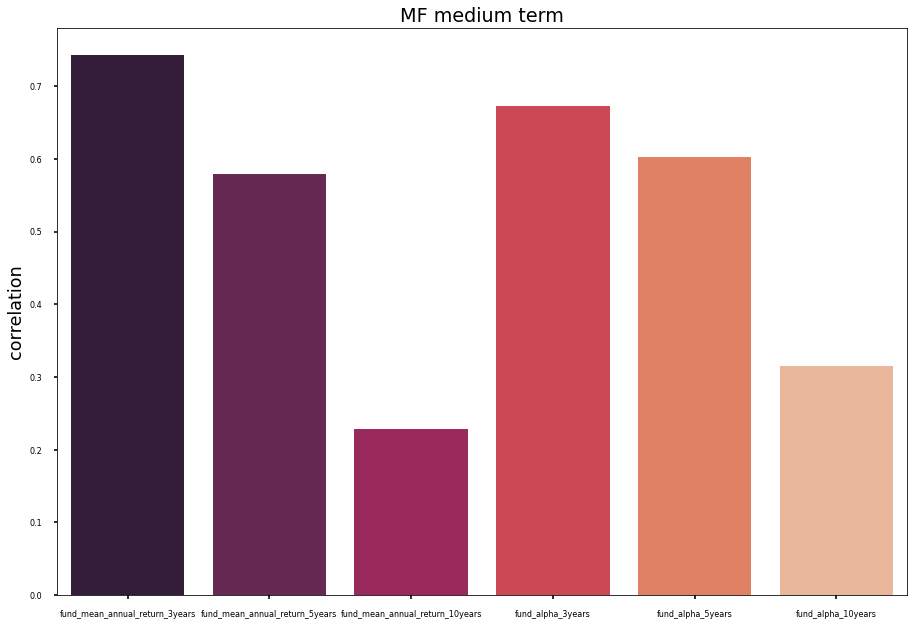

In [105]:
joined=pd.merge(df_mf,df_mf_ratios).dropna()
joined=joined.merge(df_mf_return_history).dropna()

predictors=['median_market_cap', 'bond_maturity', 'bond_duration', 'fund_yield',
        'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio']

mf_medium=get_correlations(joined,predictors,'fund_return_5years')
filter_correlations(df_corrs,df_mf_highest_corrs)
corr_visualize(df_corrs,'fund_return_5years',.20,'MF medium term',8)

### ETFS

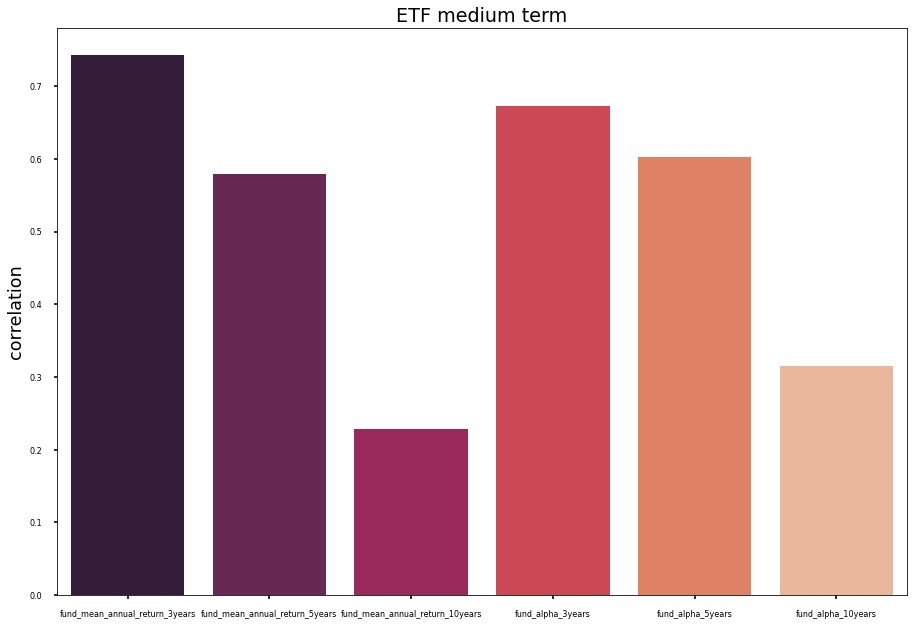

In [106]:
joined=pd.merge(df_etf,df_etf_ratios).dropna()
joined=joined.merge(df_etf_return_history).dropna()
predictors=[ 'fund_yield', 'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio']

etf_medium=get_correlations(joined,predictors,'fund_return_5years')
filter_correlations(etf_corrs,df_etf_highest_corrs)
corr_visualize(df_corrs,'fund_return_5years',.15,'ETF medium term',8)

In [107]:
mf_medium['Fund Type']='Mutual fund'
etf_medium['Fund Type']='ETF'

mf_medium.drop(['median_market_cap','bond_maturity','bond_duration','fund_net_annual_expense_ratio'],inplace=True)
etf_medium.drop(['fund_net_annual_expense_ratio'],inplace=True)


# LONG TERM

### mutual funds

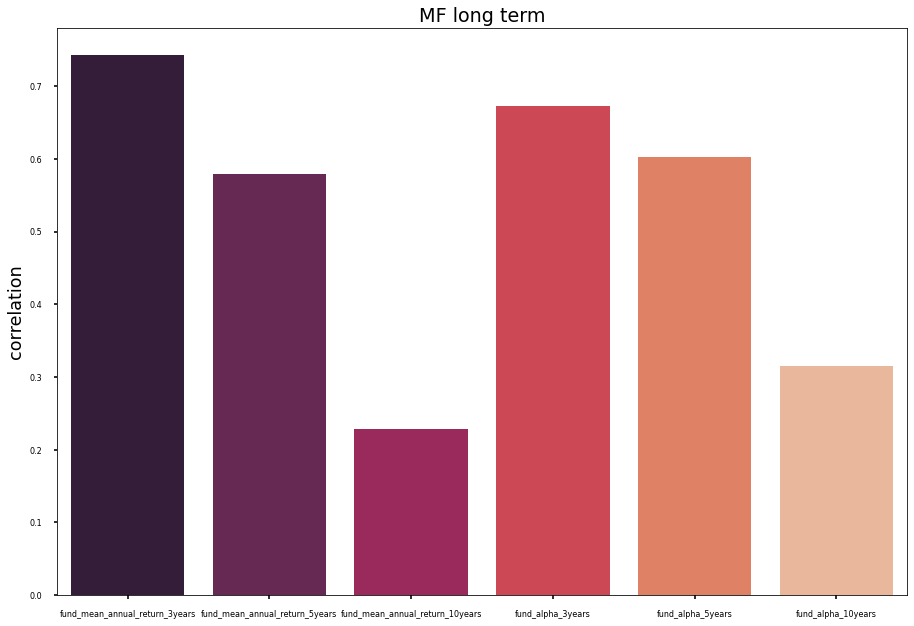

In [108]:
joined=pd.merge(df_mf,df_mf_ratios).dropna()
joined=joined.merge(df_mf_return_history).dropna()

predictors=['median_market_cap', 'bond_maturity', 'bond_duration', 'fund_yield',
        'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio',]

mf_long=get_correlations(joined,predictors,'fund_return_10years')
filter_correlations(df_corrs,df_mf_highest_corrs)
corr_visualize(df_corrs,'fund_return_10years',.20,'MF long term',8)

### ETFS

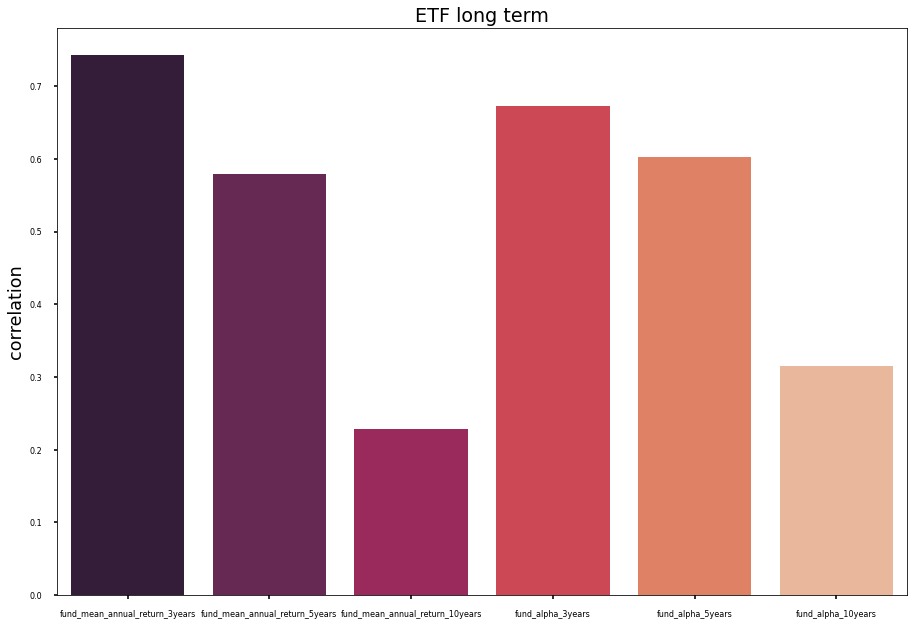

In [109]:
joined=pd.merge(df_etf,df_etf_ratios).dropna()
joined=joined.merge(df_etf_return_history).dropna()
predictors=[ 'fund_yield',
        'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio']

etf_long=get_correlations(joined,predictors,'fund_return_10years')
filter_correlations(etf_corrs,df_etf_highest_corrs)
corr_visualize(df_corrs,'fund_return_10years',.15,'ETF long term',8)

In [110]:
mf_long['Fund Type']='Mutual fund'
etf_long['Fund Type']='ETF'

mf_long.drop(['median_market_cap','bond_maturity','bond_duration','fund_net_annual_expense_ratio'],inplace=True)
etf_long.drop(['fund_net_annual_expense_ratio'],inplace=True)


__putting all this together to see different time frames within each fund type:__

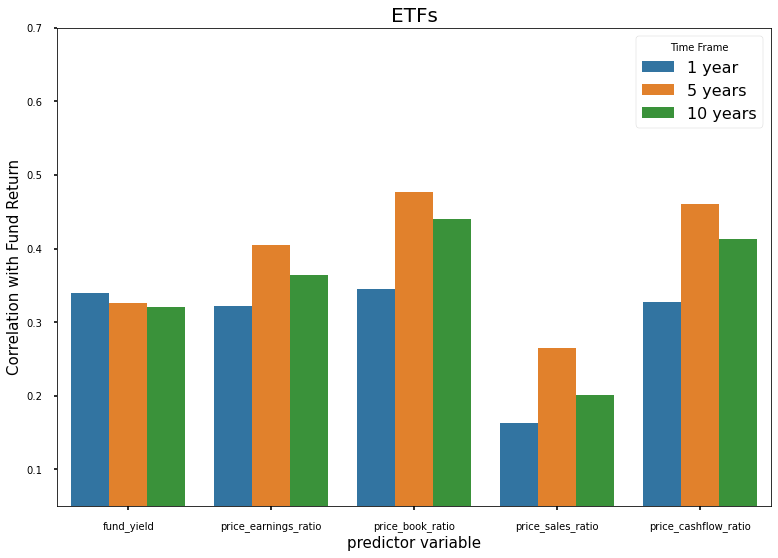

In [115]:

mf_short['Time Frame']='1 year'
etf_short['Time Frame']='1 year'


mf_medium['Time Frame']='5 years'
etf_medium['Time Frame']='5 years'

mf_long['Time Frame']='10 years'
etf_long['Time Frame']='10 years'


etf=pd.concat([etf_short,etf_medium,etf_long])

g=sns.barplot(x=etf.index,y=etf['correlation'],data=etf,hue='Time Frame')
plt.tick_params(labelsize=10)

plt.title("ETFs", fontsize = 20)
plt.xlabel("predictor variable", fontsize = 15)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
g.set_ylim(.05, .7)

mf=pd.concat([mf_short,mf_medium,mf_long])



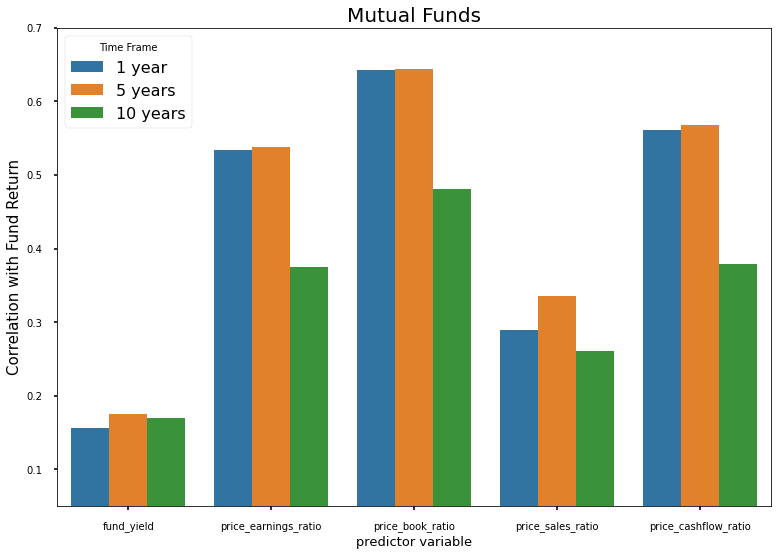

In [116]:
b=sns.barplot(x=mf.index,y=mf['correlation'],data=mf,hue='Time Frame')
plt.tick_params(labelsize=10)

plt.title("Mutual Funds", fontsize = 20)
plt.xlabel("predictor variable", fontsize = 13)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
b.set_ylim(.05, .7)
plt.show()

